In [1]:
import math
import warnings
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import statsmodels.api as sm

from scipy.stats import norm
from matplotlib import pyplot as plt
from patsy.contrasts import Treatment
from statsmodels.formula.api import glm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

%matplotlib inline
sns.set_style('white')
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_stata('https://stats.idre.ucla.edu/stat/stata/dae/binary.dta')

In [3]:
data.head()

,admit,gre,gpa,rank
0,0.0,380.0,3.61,3.0
1,1.0,660.0,3.67,3.0
2,1.0,800.0,4.00,1.0
3,1.0,640.0,3.19,4.0
4,0.0,520.0,2.93,4.0


In [4]:
dummies = pd.get_dummies(data['rank'], prefix = 'rank')

In [5]:
df = pd.concat([data, dummies], axis = 1)
df

,admit,gre,gpa,rank,rank_1.0,rank_2.0,rank_3.0,rank_4.0
0,0.0,380.0,3.61,3.0,0,0,1,0
1,1.0,660.0,3.67,3.0,0,0,1,0
2,1.0,800.0,4.00,1.0,1,0,0,0
3,1.0,640.0,3.19,4.0,0,0,0,1
4,0.0,520.0,2.93,4.0,0,0,0,1
...,...,...,...,...,...,...,...,...
395,0.0,620.0,4.00,2.0,0,1,0,0
396,0.0,560.0,3.04,3.0,0,0,1,0
397,0.0,460.0,2.63,2.0,0,1,0,0
398,0.0,700.0,3.65,2.0,0,1,0,0


In [6]:
pd.crosstab(df['admit'], df['rank'], margins = True)

rank,1.0,2.0,3.0,4.0,All
admit,,,,,
0.0,28,97,93,55,273
1.0,33,54,28,12,127
All,61,151,121,67,400


In [7]:
font = {'family' : 'Trebuchet MS',
        'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)

In [8]:
# You can use example: np.multiply(pratio, 1) to modify formula
probit_model = sm.Probit.from_formula('admit ~ gre + gpa + C(rank)', data = df)
probit_results = probit_model.fit()
probit_results.summary()

Optimization terminated successfully.
         Current function value: 0.573016
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:                  admit   No. Observations:                  400
Model:                         Probit   Df Residuals:                      394
Method:                           MLE   Df Model:                            5
Date:                Wed, 30 Mar 2022   Pseudo R-squ.:                 0.08313
Time:                        02:33:22   Log-Likelihood:                -229.21
converged:                       True   LL-Null:                       -249.99
Covariance Type:            nonrobust   LLR p-value:                 7.219e-08
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.3868      0.674     -3.541      0.000      -3.708      -1.066
C(rank)[T.2.0]    -0.4154      0.195     -2.126      0.033      -0.798      -0.032
C(rank)[T.3.0]    -0.8121      0.209     -3.893      0.000      -1.221      -0.403
C(rank)[T.4.0]    -0.9359      0.246     -3.810      0.000      -1.417      -0.454
gre                0.0014      0.001      2.120      0.034       0.000       0.003
gpa                0.4777      0.195      2.444      0.015       0.095       0.861
==================================================================================
"""

<strong><em>
For a one unit increase in gre, the z-score increases by 0.001. <br> 
    <br> 
For each one unit increase in gpa, the z-score increases by 0.478. <br> 
    <br> 
The indicator variables for rank have a slightly different interpretation. For example, having attended an undergraduate institution of rank of 2, versus an institution with a rank of 1 (the reference group), decreases the z-score by 0.415. </em></strong>

In [9]:
glm_probit_model = sm.GLM.from_formula('admit ~ gre + gpa + C(rank)', data = df,
       family = sm.families.Binomial(sm.families.links.probit()))

glm_probit_results = glm_probit_model.fit()

glm_probit_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  admit   No. Observations:                  400
Model:                            GLM   Df Residuals:                      394
Model Family:                Binomial   Df Model:                            5
Link Function:                 probit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -229.21
Date:                Wed, 30 Mar 2022   Deviance:                       458.41
Time:                        02:33:22   Pearson chi2:                     398.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.09869
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.3868      0.674     -3.542      0.000      -3.708      -1.066
C(rank)[T.2.0]    -0.4154      0.195     -2.131      0.033      -0.798      -0.033
C(rank)[T.3.0]    -0.8121      0.208     -3.898      0.000      -1.221      -0.404
C(rank)[T.4.0]    -0.9359      0.245     -3.816      0.000      -1.417      -0.455
gre                0.0014      0.001      2.116      0.034       0.000       0.003
gpa                0.4777      0.197      2.423      0.015       0.091       0.864
==================================================================================
"""

<strong><em>
The two APIs give the same results.
</em></strong>

In [10]:
# Covariance
cov = probit_results.cov_params()
cov

,Intercept,C(rank)[T.2.0],C(rank)[T.3.0],C(rank)[T.4.0],gre,gpa
Intercept,0.454395,-0.035094,-0.024902,-0.037069,-1.065491e-04,-0.104977
C(rank)[T.2.0],-0.035094,0.038172,0.026793,0.027028,2.063946e-06,0.002028
C(rank)[T.3.0],-0.024902,0.026793,0.043512,0.026904,9.237129e-06,-0.002198
C(rank)[T.4.0],-0.037069,0.027028,0.026904,0.060336,7.449464e-06,0.001644
gre,-0.000107,0.000002,0.000009,0.000007,4.210262e-07,-0.000044
gpa,-0.104977,0.002028,-0.002198,0.001644,-4.386750e-05,0.038206


In [11]:
# Marginal effect in this types of models are not about a unit change but a really small change
AME = probit_results.get_margeff(at = 'overall', dummy = True)
AME.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
       Probit Marginal Effects       
=====================================
Dep. Variable:                  admit
Method:                          dydx
At:                           overall
==================================================================================
                    dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
C(rank)[T.2.0]    -0.1287      0.057     -2.272      0.023      -0.240      -0.018
C(rank)[T.3.0]    -0.2413      0.053     -4.564      0.000      -0.345      -0.138
C(rank)[T.4.0]    -0.2538      0.050     -5.061      0.000      -0.352      -0.156
gre                0.0004      0.000      2.154      0.031    4.03e-05       0.001
gpa                0.1552      0.062      2.494      0.013       0.033       0.277
==================================================================================
"""

In [12]:
# probability at each info from dataframe
# probit_results.predict() gives a array
# probit_results.predict(exog = df[['gre', 'gpa', 'rank']])
# Linear = False gives the CDF and it's the defalt parameter in predict
pred_df = probit_results.predict(exog = df, linear = False)
pred_df = pred_df.reset_index()
pred_df.set_index('index', inplace = True)
pred_df.rename(columns = {0: 'prob'}, inplace = True)
pred_df.index.rename('id', inplace = True)
new_df = pd.concat([df, pred_df], axis = 1)
new_df

,admit,gre,gpa,rank,rank_1.0,rank_2.0,rank_3.0,rank_4.0,prob
0,0.0,380.0,3.61,3.0,0,0,1,0,0.170639
1,1.0,660.0,3.67,3.0,0,0,1,0,0.295352
2,1.0,800.0,4.00,1.0,1,0,0,0,0.733869
3,1.0,640.0,3.19,4.0,0,0,0,1,0.179205
4,0.0,520.0,2.93,4.0,0,0,0,1,0.113585
...,...,...,...,...,...,...,...,...,...
395,0.0,620.0,4.00,2.0,0,1,0,0,0.484665
396,0.0,560.0,3.04,3.0,0,0,1,0,0.164447
397,0.0,460.0,2.63,2.0,0,1,0,0,0.180612
398,0.0,700.0,3.65,2.0,0,1,0,0,0.461916


In [13]:
probit_pred = probit_results.predict()

In [14]:
# Confusion Matrix
cnf_matrix = probit_results.pred_table()

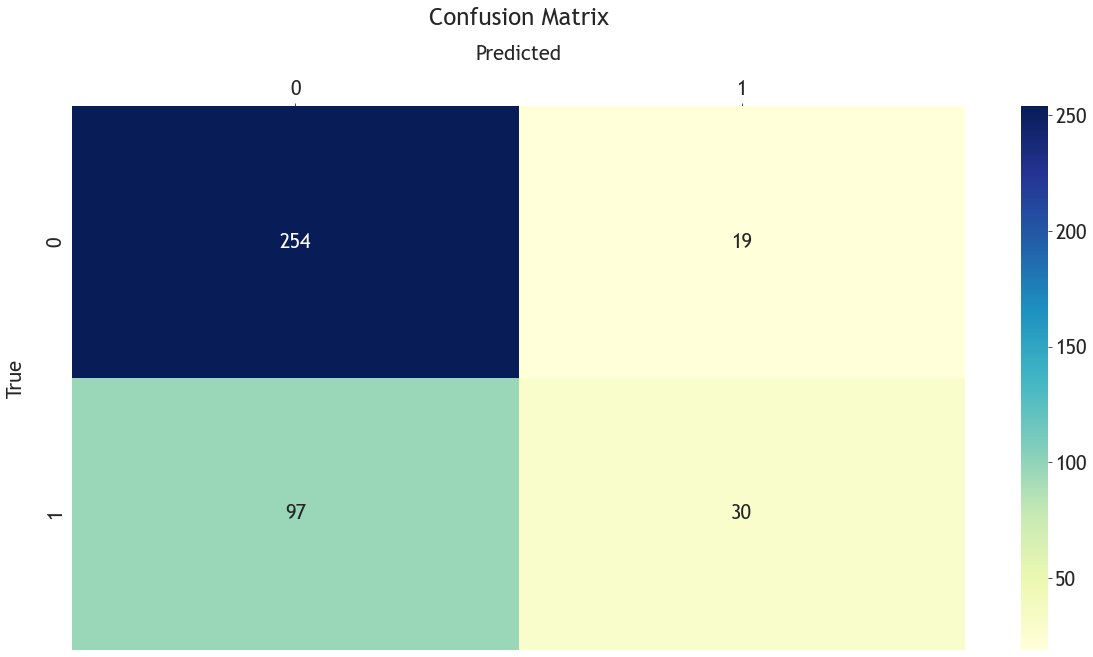

In [15]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = 'YlGnBu' ,fmt = 'g')
ax.set_title('Confusion Matrix', pad = 20)
ax.set_xlabel('Predicted', labelpad = 20)    
ax.set_ylabel('True', labelpad = 20) 
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.show()

In [16]:
# ROC - 
roc_fpr, roc_tpr, roc_thresholds = roc_curve(df['admit'], probit_pred)

# AUROC - 
auroc = roc_auc_score(df['admit'], probit_pred)
percent_auroc = auroc*100

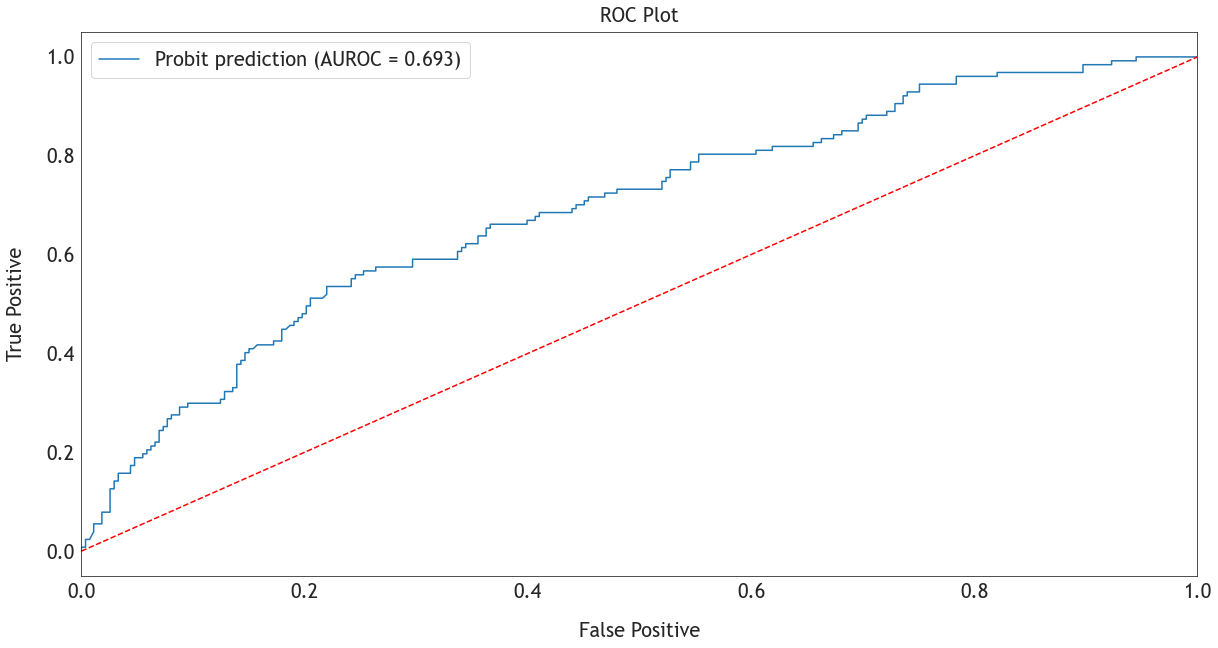

In [17]:
fig = plt.subplots(figsize=(20, 10))
plt.plot(roc_fpr, roc_tpr, label = 'Probit prediction (AUROC = %0.3f)' % auroc)
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC Plot', fontsize = 20, pad = 10)
plt.xlabel('False Positive', labelpad = 20)
plt.ylabel('True Positive', labelpad = 20)
plt.xlim([0, 1])
plt.legend()
plt.show()

In [18]:
prediction = probit_results.predict(exog = {'gre': 800, 'gpa': 4, 'rank': 1}, linear = False)
print('With GRE = 800, GPA = 4.0 and Rank = 1, theres a', '{:.4%}'.format(prediction[0]), 'chance to get admitted')

With GRE = 800, GPA = 4.0 and Rank = 1, theres a 73.3869% chance to get admitted


In [19]:
data_predict = pd.DataFrame(
        [np.linspace(start = df['gre'].min(), stop = df['gre'].max(), num = df.shape[0])],
         index = ['gre']).T

# Constants, GPA 4.0 and Rank 1 Uni
data_predict['gpa'] = 4
data_predict['rank'] = 1

data_predict.head()

,gre,gpa,rank
0,220.000000,4,1
1,221.453634,4,1
2,222.907268,4,1
3,224.360902,4,1
4,225.814536,4,1


In [20]:
# Predicted probability when gre changes but gpa is 4.0 and from rank 1 uni
probit_pred = probit_results.predict(exog = data_predict, linear = False)

In [21]:
probit_pred

0      0.431213
1      0.431999
2      0.432785
3      0.433572
4      0.434359
         ...   
395    0.731237
396    0.731896
397    0.732555
398    0.733212
399    0.733869
Length: 400, dtype: float64

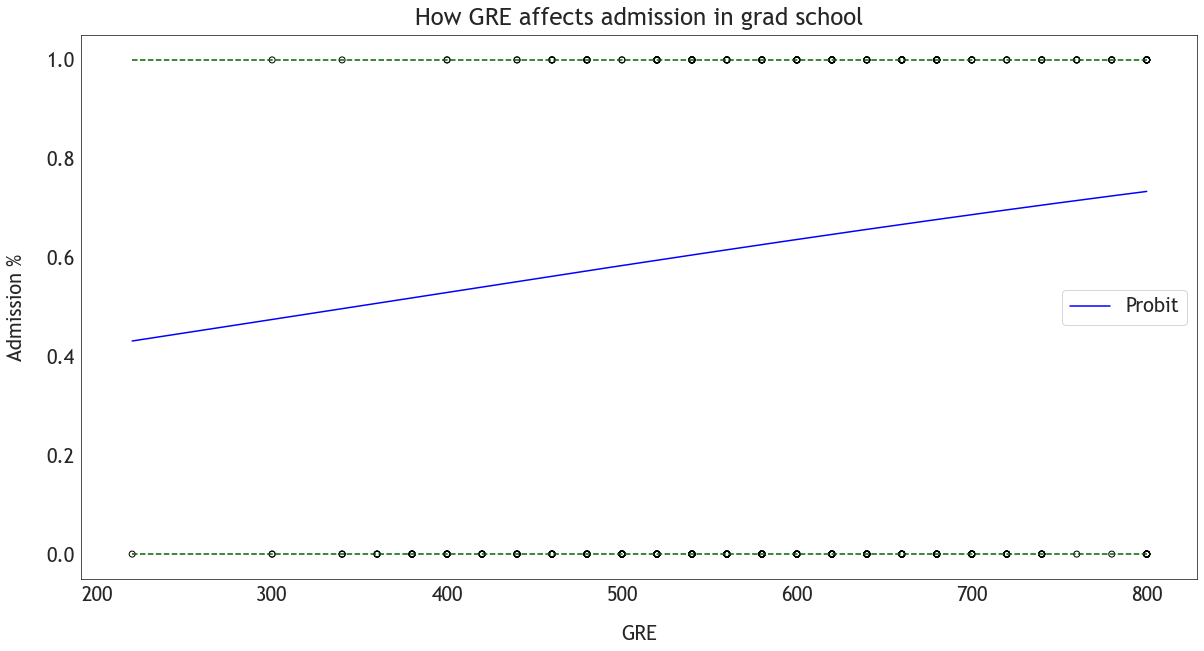

In [22]:
fig = plt.figure(figsize = (20, 10))

plt.scatter(df['gre'], df['admit'], edgecolor = 'black', color = 'None', label = '_nolegend_')

plt.plot(data_predict['gre'], probit_pred, color = 'blue', label = 'Probit')

plt.hlines(y = [0, 1], linestyles = 'dashed', color = 'darkgreen', label = '_nolegend_',
           xmin = data_predict['gre'].min(), xmax = data_predict['gre'].max())

plt.title('How GRE affects admission in grad school', pad = 10)
plt.xlabel('GRE', labelpad = 20)
plt.ylabel('Admission %', labelpad = 20)
plt.legend(loc = 'center right')
plt.show()

In [23]:
# One way to predict if going to be admited or not:
threshold = 0.5
predicted_choice = (probit_pred > threshold).astype(int)

# Other way is:
# predicted_choice = round(probit_pred)

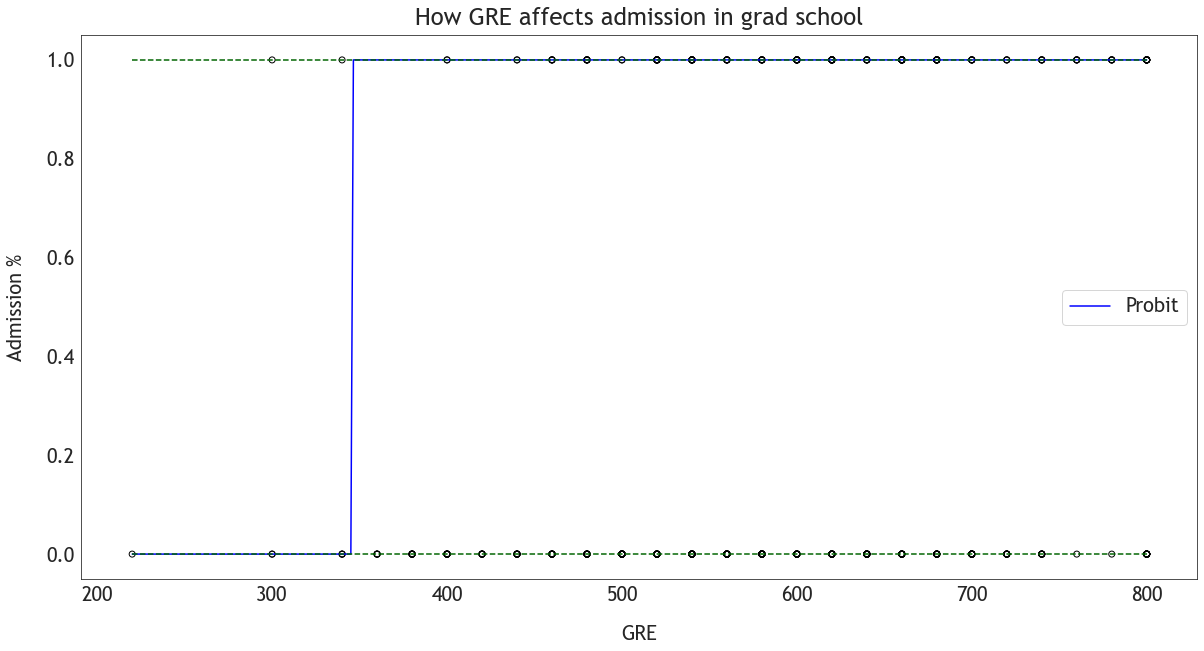

In [24]:
fig = plt.figure(figsize = (20, 10))

plt.scatter(df['gre'], df['admit'], edgecolor = 'black', color = 'None', label = '_nolegend_')

plt.plot(data_predict['gre'], predicted_choice, color = 'blue', label = 'Probit')

plt.hlines(y = [0, 1], linestyles = 'dashed', color = 'darkgreen', label = '_nolegend_',
           xmin = data_predict['gre'].min(), xmax = data_predict['gre'].max())

plt.title('How GRE affects admission in grad school', pad = 10)
plt.xlabel('GRE', labelpad = 20)
plt.ylabel('Admission %', labelpad = 20)
plt.legend(loc = 'center right')
plt.show()

In [25]:
gre = np.linspace(start = 200, stop = 800, num = 100)
gre = np.resize(gre, 400)                  
gpa = pd.Series([2.5, 3.0, 3.5, 4.0])
gpa = gpa.repeat(100)
rank = pd.Series([1, 2, 3, 4])
rank = np.resize(rank, 400)


multi_data_predict = pd.DataFrame([gre, gpa, rank],
         index = ['gre', 'gpa', 'rank']).T


multi_data_predict

,gre,gpa,rank
0,200.000000,2.5,1.0
1,206.060606,2.5,2.0
2,212.121212,2.5,3.0
3,218.181818,2.5,4.0
4,224.242424,2.5,1.0
...,...,...,...
395,775.757576,4.0,4.0
396,781.818182,4.0,1.0
397,787.878788,4.0,2.0
398,793.939394,4.0,3.0


In [26]:
# Predicted probability when gre changes but gpa is 4.0 and from rank 1 uni
multi_probit_pred = probit_results.predict(exog = multi_data_predict, linear = False)

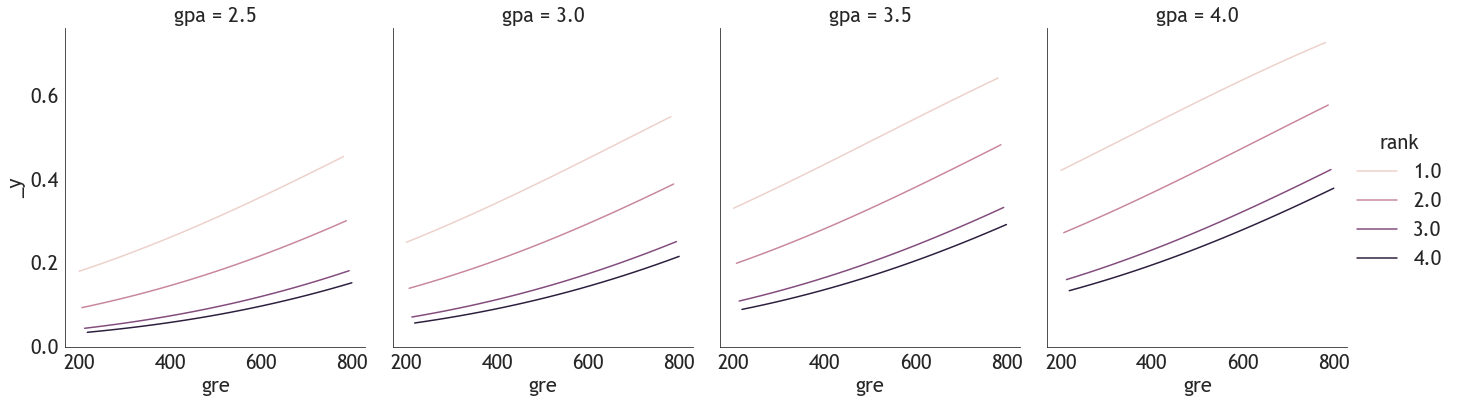

In [27]:
sns.relplot(multi_data_predict['gre'], multi_probit_pred, 
            hue = multi_data_predict['rank'], col = multi_data_predict['gpa'], 
            kind = 'line', height = 6, aspect = 0.8, facet_kws = dict(sharex = True))

plt.show()